<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/067_Contrastive_Learning_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌗 Contrastive Learning (SimCLR): Nauka bez Nauczyciela

Jak dziecko uczy się, co to jest "krzesło"? Nie ogląda 1000 zdjęć z etykietą "krzesło".
Ogląda krzesło z różnych stron, w różnym oświetleniu i rozumie, że **to ciągle ten sam obiekt**.

Tak działa SimCLR.
Generujemy **Pary Pozytywne** (dwa widoki tego samego obrazka) i zmuszamy sieć, żeby kodowała je w tym samym punkcie przestrzeni.

**Kluczowe elementy:**
1.  **Augmentacja:** Musi być agresywna (zmiana kolorów, wycinanie fragmentów).
2.  **NT-Xent Loss:** Funkcja kosztu, która przyciąga pary pozytywne i odpycha wszystko inne (pary negatywne).
3.  **Projekcja:** Uczymy się na wektorach z "głowy projekcyjnej" (MLP), którą potem... wyrzucamy.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

# Konfiguracja
BATCH_SIZE = 64 # W SimCLR im większy batch, tym lepiej (więcej negatywów)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Urządzenie: {DEVICE}")

Urządzenie: cuda


## Krok 1: Augmentacja Danych (Tworzenie Par)

To najważniejszy krok. Musimy stworzyć klasę Dataset, która dla każdego zdjęcia zwraca **DWIE** jego wersje ($x_i$ i $x_j$).
Użyjemy losowego przycinania (Crop) i zniekształceń kolorów (Jitter).

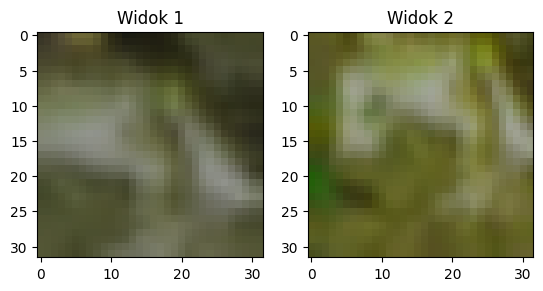

To jest ten sam obiekt, ale wygląda inaczej. Sieć musi to zrozumieć.


In [3]:
class SimCLRTransform:
    def __init__(self, size):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1), # Agresywne kolory
            transforms.ToTensor()
        ])

    def __call__(self, x):
        # Zwracamy DWIE wersje tego samego obrazka
        return self.transform(x), self.transform(x)

# Pobieramy CIFAR-10 (małe obrazki 32x32)
dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=SimCLRTransform(32))
loader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

# --- POPRAWKA ---
# dataset[0] zwraca ((img1, img2), label)
# Bierzemy tylko images_tuple, czyli dataset[0][0]
images_tuple, label = dataset[0]
img1, img2 = images_tuple 

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1.permute(1, 2, 0))
ax[0].set_title("Widok 1")
ax[1].imshow(img2.permute(1, 2, 0))
ax[1].set_title("Widok 2")
plt.show()

print("To jest ten sam obiekt, ale wygląda inaczej. Sieć musi to zrozumieć.")

## Krok 2: Model (Encoder + Projection Head)

Jako Encodera użyjemy małego ResNet-a (ResNet18).
Na jego końcu dodamy **Głowicę Projekcyjną** (Projection Head) – małą sieć MLP.

*Ciekawostka:* Po treningu wyrzucamy głowicę do kosza i używamy tylko Encodera (ResNet). Okazuje się, że Encoder uczy się lepszych cech, jeśli "głupią robotę" dopasowywania wektorów zostawi Głowicy.

In [5]:
class SimCLR(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Encoder (ResNet18 bez ostatniej warstwy)
        # POPRAWKA: Zamiast pretrained=False, używamy weights=None
        resnet = models.resnet18(weights=None)
        
        # ResNet18 ma na wyjściu 512 cech. Usuwamy warstwę fc (klasyfikator 1000 klas)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        # 2. Projection Head (MLP: 512 -> 256 -> 128)
        self.projection = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        h = self.encoder(x) # Reprezentacja (Features)
        z = self.projection(h) # Projekcja (do liczenia straty)
        return h, z

model = SimCLR().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Model SimCLR gotowy (Warnings naprawione).")

Model SimCLR gotowy (Warnings naprawione).


## Krok 3: NT-Xent Loss (Normalized Temperature-scaled Cross Entropy)

To brzmi strasznie, ale to po prostu Softmax z Temperaturą (którą znasz z notatnika 12!).

Dla każdego obrazka w batchu (N):
1.  Mamy 1 parę pozytywną (ten sam obrazek, inna wersja).
2.  Mamy $2(N-1)$ par negatywnych (wszystkie inne obrazki w batchu).

Chcemy zmaksymalizować podobieństwo pozytywu i zminimalizować podobieństwo negatywów.
Używamy **Cosine Similarity**.

In [6]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    
    # KROK 1: Sklejamy wszystko w jeden duży tensor [2N, D]
    # Pierwsze N to widoki nr 1, kolejne N to widoki nr 2
    z = torch.cat([z_i, z_j], dim=0)
    
    # KROK 2: Obliczamy macierz podobieństwa (Cosine Similarity) każdy z każdym
    # Najpierw normalizacja wektorów
    z = F.normalize(z, dim=1)
    # Mnożenie macierzy (Similarity Matrix)
    sim_matrix = torch.matmul(z, z.T) / temperature
    
    # KROK 3: Maska (żeby nie porównywać obrazka z samym sobą)
    mask = torch.eye(2 * batch_size, device=DEVICE).bool()
    # Wypełniamy przekątną bardzo małą liczbą (żeby Softmax ją zignorował)
    sim_matrix.masked_fill_(mask, -9e15)
    
    # KROK 4: Etykiety (Labels)
    # Dla obrazka i (0), pozytywem jest obrazek i+N (N)
    labels = torch.cat([
        torch.arange(batch_size, 2*batch_size, device=DEVICE),
        torch.arange(0, batch_size, device=DEVICE)
    ], dim=0)
    
    # KROK 5: Cross Entropy
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

print("Funkcja kosztu zdefiniowana.")

Funkcja kosztu zdefiniowana.


Start treningu SimCLR...
Epoka 1, Loss: 3.9294
Epoka 2, Loss: 3.7801
Epoka 3, Loss: 3.7039
Epoka 4, Loss: 3.6517
Epoka 5, Loss: 3.6259


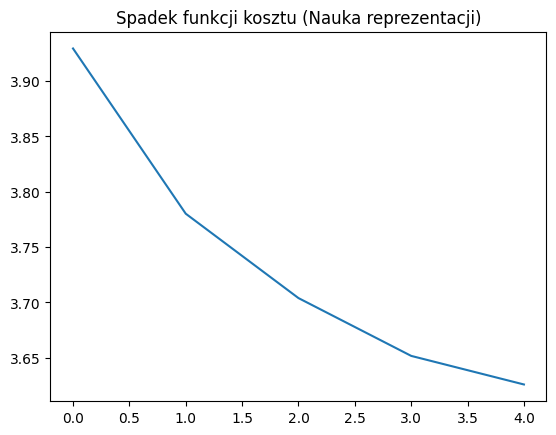

In [8]:
# PĘTLA TRENINGOWA (Poprawiona struktura danych)

print("Start treningu SimCLR...")
model.train()

losses = []
for epoch in range(5): # 5 epok
    epoch_loss = 0
    
    # POPRAWKA: Loader zwraca ((img1, img2), labels)
    # Rozpakowujemy to poprawnie:
    for batch_idx, (images, _) in enumerate(loader):
        x_i, x_j = images # Wyciągamy dwa widoki z listy
        x_i, x_j = x_i.to(DEVICE), x_j.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward (dla obu widoków)
        _, z_i = model(x_i)
        _, z_j = model(x_j)
        
        # Loss
        loss = nt_xent_loss(z_i, z_j)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoka {epoch+1}, Loss: {avg_loss:.4f}")

plt.plot(losses)
plt.title("Spadek funkcji kosztu (Nauka reprezentacji)")
plt.show()

## 🧠 Podsumowanie: Fundament CLIP

To, co właśnie zbudowaliśmy, to fundament modelu **CLIP** od OpenAI.
CLIP działa tak samo, tylko zamiast dwóch zdjęć ($img_1$, $img_2$), paruje **zdjęcie** i **tekst** ($img$, $text$).

Dzięki temu sieć uczy się:
*   Wektor zdjęcia "Pies" $\approx$ Wektor tekstu "Pies".
*   Wektor zdjęcia "Pies" $\neq$ Wektor tekstu "Banan".

W ten sposób AI rozumie świat bez konieczności ręcznego zaznaczania miliona ramek.